In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import ast
from adjustText import adjust_text

In [53]:
def load_result(file_path):
    with open(file_path, 'r') as f:
        # read last line and grab metrics info as a dict
        result = ast.literal_eval(f.readlines()[-1].split('[INFO] ')[1])

    return result
'''
    results_path: list of paths to dir containing LAVIS output files
'''
def load_results(results_paths):
    
    gather = []
    
    for name, path in results_paths:
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            result = load_result(file_path)
            result['Quantized Portion'] = name
            result['file_name'] = file_name
            gather.append(result)
    
    df_results = pd.DataFrame(gather)
    
    weight_bits = df_results.file_name.str.extract(r'w(\d*)')
    df_results['weight_bits'] = [float(x) if x != '158' else 1.58 for x in weight_bits[0]]
    
    act_bits = df_results.file_name.str.extract(r'a(\d*)')
    df_results['activation_bits'] = [float(x) if x != '158' else 1.58 for x in act_bits[0]]

    return df_results

In [54]:
baseline_result = load_result(os.path.join('..', 'results', 'blip2_flickr', 'blip2_flickr_baseline.2714895'))
baseline_result['Quantized Portion'] = 'baseline'
baseline_result['file_name'] = 'baseline'
baseline_result['weight_bits'] = 32.0
baseline_result['activation_bits'] = 32.0

baseline_result = pd.DataFrame([baseline_result])
baseline_result

,txt_r1,txt_r5,txt_r10,txt_r_mean,img_r1,img_r5,img_r10,img_r_mean,r_mean,agg_metrics,Quantized Portion,file_name,weight_bits,activation_bits
0,97.6,100.0,100.0,99.2,89.74,98.18,98.94,95.62,97.41,99.2,baseline,baseline,32.0,32.0


## Uniform Quantization

+ https://pocketflow.github.io/uq_learner/#algorithm

In [55]:
results_path =[
                ('ViT Attention', os.path.join('..', 'results', 'blip2_flickr', 'uniform_quant', 'vision_attention_head')),
                ('Q-Former (Img + Text) Attention', os.path.join('..', 'results', 'blip2_flickr', 'uniform_quant', 'qformer_image_and_text'))
              ]
results_path

[('ViT Attention',
  '../results/blip2_flickr/uniform_quant/vision_attention_head'),
 ('Q-Former (Img + Text) Attention',
  '../results/blip2_flickr/uniform_quant/qformer_image_and_text')]

In [56]:
df_results = load_results(results_path)
df_results = pd.concat([baseline_result, df_results], axis = 0)
df_results = df_results.drop(['txt_r_mean','img_r_mean', 'r_mean', 'agg_metrics'], axis = 1)

# df_results = pd.melt(df_results, id_vars=['file_name', 'weight_bits', 'activation_bits'], var_name='metric')

df_results

,txt_r1,txt_r5,txt_r10,img_r1,img_r5,img_r10,Quantized Portion,file_name,weight_bits,activation_bits
0,97.6,100.0,100.0,89.74,98.18,98.94,baseline,baseline,32.00,32.0
0,52.7,70.2,76.1,47.20,67.50,74.72,ViT Attention,vit_w4_a32,4.00,32.0
1,54.2,71.5,78.2,49.04,69.46,76.70,ViT Attention,vit_w6_a32,6.00,32.0
2,18.0,30.4,37.8,19.14,34.06,41.46,ViT Attention,vit_w2_a32,2.00,32.0
3,58.0,76.6,83.0,56.70,76.12,81.72,ViT Attention,vit_w158_a32,1.58,32.0
4,55.2,72.2,78.1,49.52,70.14,77.38,ViT Attention,vit_w8_a32,8.00,32.0
5,97.7,100.0,100.0,89.02,98.04,98.98,Q-Former (Img + Text) Attention,qformer_w6_a32,6.00,32.0
6,97.8,100.0,100.0,88.72,98.10,99.04,Q-Former (Img + Text) Attention,qformer_w4_a32,4.00,32.0
7,84.7,98.4,99.7,72.70,91.68,95.18,Q-Former (Img + Text) Attention,qformer_w2_a32,2.00,32.0
8,97.9,99.9,100.0,89.04,98.00,99.00,Q-Former (Img + Text) Attention,qformer_w8_a32,8.00,32.0


In [79]:
def plot(df, x, y, title = ''):
    
    sns.set_theme()
    ax = sns.lineplot(data= df,
                      x = x,
                      y = y,
                      marker = 'o',
                      hue = 'Quantized Portion')

    texts = []
    
    # label points on the plot
    for x_val, y_val in zip(df[x], df[y]):
        texts.append(plt.text(x = x_val, 
                              y = y_val, 
                              s = f'{y_val:.2f}', 
                              color = 'blue'))

    
    x_ticks = np.append(ax.get_xticks(), df[x])

    # Set xtick locations to the values of the array `x_ticks`
    ax.set_xticks(x_ticks)
    ax.invert_xaxis()
    
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    
    plt.title(title)
    plt.ylabel(y)
    
    
def plot_all_recall(df, x, title = ''):
    
    
    df = pd.melt(df, id_vars=['Quantized Portion', 'file_name', 'weight_bits', 'activation_bits'], var_name='metric')
    
    
    sns.set_theme()
    
    y = 'value'
    ax = sns.lineplot(data= df,
                      x = x,
                      y = y,
                      marker = 'o',
                      hue = 'metric')

    texts = []
    
    # label points on the plot
    for x_val, y_val in zip(df[x], df[y]):
        texts.append(plt.text(x = x_val, 
                              y = y_val, 
                              s = f'{y_val:.2f}', 
                              color = 'blue'))

    
    x_ticks = np.append(ax.get_xticks(), df[x])

    # Set xtick locations to the values of the array `x_ticks`
    ax.set_xticks(x_ticks)
    ax.invert_xaxis()
    
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    
    plt.title(title)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()
    

Img --> Text Retrieval

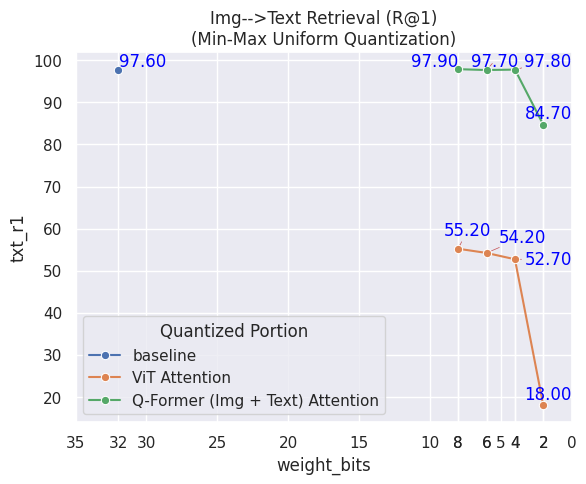

In [80]:
plot(df_results[df_results.weight_bits >= 2.0], 
     x = 'weight_bits', 
     y = 'txt_r1',
     title = 'Img-->Text Retrieval (R@1)\n(Min-Max Uniform Quantization)')

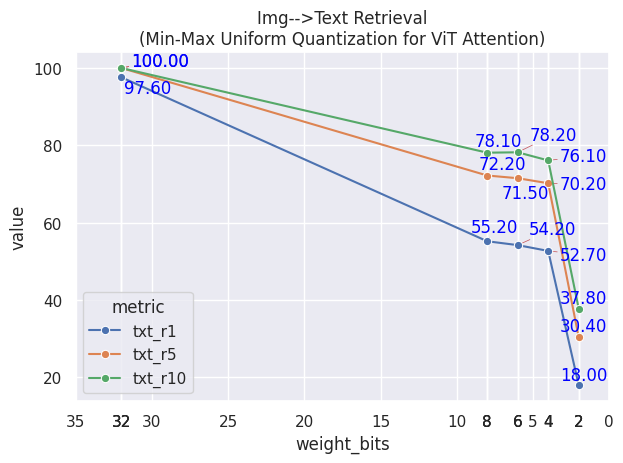

In [81]:
df = df_results[df_results['Quantized Portion'].isin(['baseline', 'ViT Attention'])]
df = df.drop(['img_r1', 'img_r5', 'img_r10'], axis = 1)

plot_all_recall(df[df.weight_bits >= 2.0],
                'weight_bits',
                'Img-->Text Retrieval\n(Min-Max Uniform Quantization for ViT Attention)')

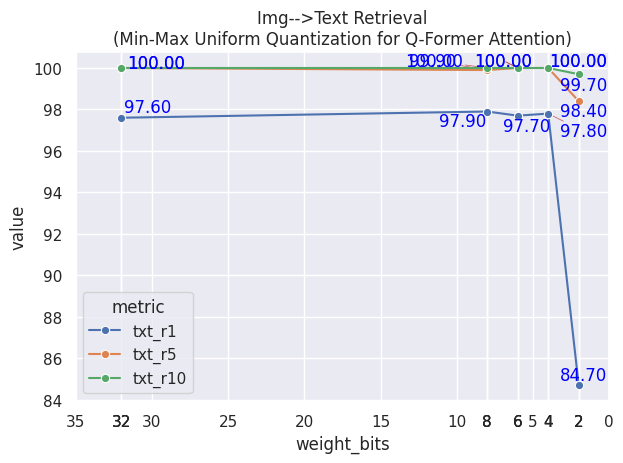

In [88]:
df = df_results[df_results['Quantized Portion'].isin(['baseline', 'Q-Former (Img + Text) Attention'])]
df = df.drop(['img_r1', 'img_r5', 'img_r10'], axis = 1)

plot_all_recall(df[df.weight_bits >= 2.0],
                'weight_bits',
                'Img-->Text Retrieval\n(Min-Max Uniform Quantization for Q-Former Attention)')

Text-->Image Retrieval

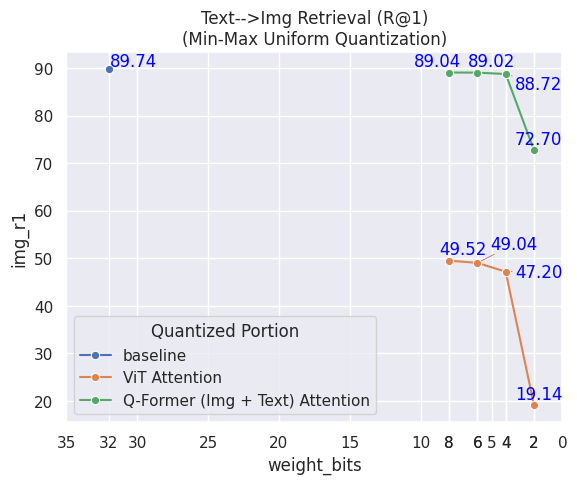

In [82]:
plot(df_results[df_results.weight_bits >= 2.0], 
     x = 'weight_bits', 
     y = 'img_r1',
     title = 'Text-->Img Retrieval (R@1)\n(Min-Max Uniform Quantization)')

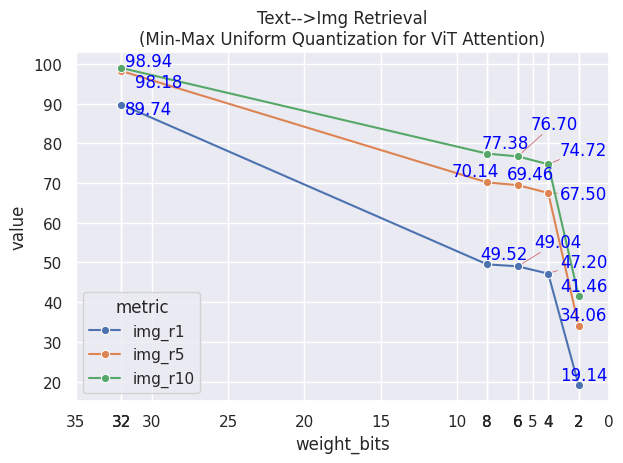

In [87]:
df = df_results[df_results['Quantized Portion'].isin(['baseline', 'ViT Attention'])]
df = df.drop(['txt_r1', 'txt_r5', 'txt_r10'], axis = 1)

plot_all_recall(df[df.weight_bits >= 2.0],
                'weight_bits',
                'Text-->Img Retrieval\n(Min-Max Uniform Quantization for ViT Attention)')

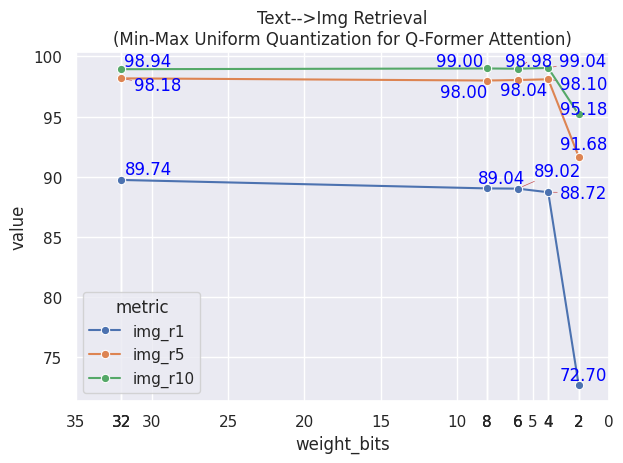

In [90]:
df = df_results[df_results['Quantized Portion'].isin(['baseline', 'Q-Former (Img + Text) Attention'])]
df = df.drop(['txt_r1', 'txt_r5', 'txt_r10'], axis = 1)

plot_all_recall(df[df.weight_bits >= 2.0],
                'weight_bits',
                'Text-->Img Retrieval\n(Min-Max Uniform Quantization for Q-Former Attention)')